In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import sys

sys.path.append(os.getcwd()[:-10])
from functools import partial
from utils.performance_metrics import *
from serial_momentum_functions import *

### Grid searching for hyperparameter tuning

In the first notebook, we discussed the basic ideas of a serial momentum strategy, from finding optimal past-future pairs that maximises correlation of returns, to creating positions via Hurst exponents.

The next idea is to tune hyperparameters. While there are many industrial methods (e.g optuna), we'll use a simple grid search for this project.

In [2]:
train_data = yf.download('GS',
                         start='2010-01-01',
                         end='2017-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
# optimal past-future pair
lookback = 30
forward = 25

# rolling window of hurst exponents
hurst_exponents = generate_hurst_array(log_prices=np.log(train_data.values),
                                       rolling_window=lookback)

# past returns
past_returns = train_data.pct_change(lookback)

# feeding hurst exponents and past returns to strategy
momentum_strategy = partial(create_portfolio_positions,
                            past_returns=past_returns,
                            hurst_exponents=hurst_exponents,
                            forward=forward)

In [4]:
gridsearch_results = grid_search(price_data=train_data.to_frame(),
                                 strategy=momentum_strategy,
                                 hyperparameters={'entry_hurst': np.linspace(0.55, 0.7, 16),
                                                  'exit_hurst': np.linspace(0.3, 0.45, 16)},
                                 commissions_in_percent=0.25,
                                 bid_ask_spread=0.01)

100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 181.92it/s]


In [5]:
gridsearch_results.sort_values('sharpe_ratio', ascending=False).head()

,entry_hurst,exit_hurst,annual_returns,sharpe_ratio
155,0.57,0.43,0.118,1.494
106,0.58,0.43,0.105,1.454
140,0.57,0.45,0.108,1.437
93,0.55,0.45,0.118,1.432
113,0.58,0.42,0.103,1.421


In [6]:
gridsearch_results.sort_values('annual_returns', ascending=False).head()

,entry_hurst,exit_hurst,annual_returns,sharpe_ratio
155,0.57,0.43,0.118,1.494
93,0.55,0.45,0.118,1.432
114,0.55,0.43,0.118,1.397
139,0.56,0.43,0.114,1.372
161,0.57,0.42,0.112,1.420


### Observations

Unlike the mean reversion results, it seems that we have found a sweet spot that gives us good annual returns and sharpe ratios. Let's use iteration #155 for our out-of-sample test.

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

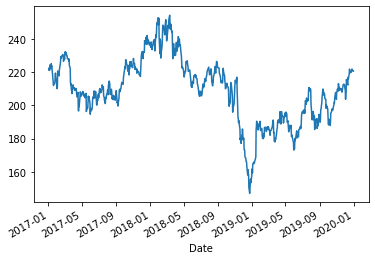

In [7]:
test_data = yf.download('GS',
                        start='2017-01-01',
                        end='2020-01-01')['Adj Close']

test_data.plot()

In [8]:
# optimal past-future pair
lookback = 30
forward = 25

# rolling window of hurst exponents
hurst_exponents = generate_hurst_array(log_prices=np.log(test_data.values),
                                       rolling_window=lookback)

# past returns
past_returns = test_data.pct_change(lookback)

# hyperparameters optimised from grid search
optimal_entry_hurst = gridsearch_results.loc[155].entry_hurst
optimal_exit_hurst = gridsearch_results.loc[155].exit_hurst

In [9]:
positions, portfolio_ratios =\
    create_portfolio_positions(price_data=test_data.to_frame(),
                               past_returns=past_returns,
                               hurst_exponents=hurst_exponents,
                               forward=forward,
                               entry_hurst=optimal_entry_hurst,
                               exit_hurst=optimal_exit_hurst)

Annual returns: -0.019
Sharpe ratio: -0.137


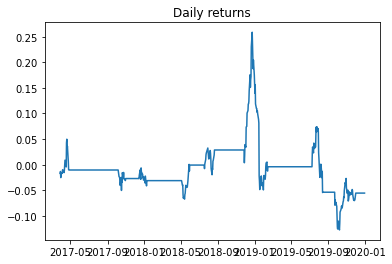

In [10]:
annual_returns, sharpe_ratio =\
    calculate_pnl_with_transaction_costs(price_data=test_data.to_frame(),
                                         positions=positions,
                                         portfolio_ratios=portfolio_ratios,
                                         commissions_in_percent=0.25,
                                         bid_ask_spread=0.01)

print(f"Annual returns: {annual_returns}")
print(f"Sharpe ratio: {sharpe_ratio}")

### Observations

Unfortunately, the test results in this case are poor, with negative returns. This is an example of model overfitting to training data. Momentum based strategies tend to be more difficult to build as they often overfit on the training set and generalise poorly.

### Improvements

Some improvements to the simple momentum strategy are:
- Events based backtesting: use higher granularity data and allows more complex strategy behaviours (e.g dynamic capital allocation to strategy based on whether it is winning/losing in past window)
- Volume sampling: using volume clock rather than human time clock to capture information uniformly.
- Zscore calculations: Alternative to Hurst exponents, calculate zscores over past returns and trade when zscores cross thresholds.
- Calculating past returns with linear regression (compare entire lookback period rather than 2 data points)
    - Trade only when linear regression fits well (R-squared is above a threshold)
- Triple barrier method: Recommended by Marcos López de Prado, provides a framework for taking profits, cutting losses and hitting timestops.